In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

from retrieval_base.model_components.chemistry import get_class

from tqdm import tqdm

In [ ]:
def get_VMR(Chem, hill_notation):
    idx = Chem.fastchem.getGasSpeciesIndex(hill_notation)
    
    n = np.array(Chem.output.number_densities)
    n_tot = n.sum(axis=1)

    return (n[:,idx] / n_tot)[::-1]

In [3]:
T_eff_i, FeH_i = 1300.0, 0.0

# Read temperature profile
path = '/net/lem/data2/regt/SONORA_Elf_Owl/PT_profiles/' + \
    'spectra_logzz_7.0_teff_{:.1f}_grav_1000.0_mh_{:.1f}_co_1.0.dat'.format(T_eff_i, FeH_i)
pressure, temperature = np.loadtxt(path).T

chem_kwargs = dict(
    chem_mode = 'fastchem', 
    line_species = [
        '1H2-16O__POKAZATEL', 
        '1H2-18O__HotWat78', 
        '1H2-17O__HotWat78', 

        '12C-16O__HITEMP', 
        '13C-16O__HITEMP', 
        '12C-18O__HITEMP', 
        '12C-17O__HITEMP', 
        
        '12C-1H4__MM', 
        '14N-1H3__CoYuTe', 
        
        '12C-16O2__HITEMP', 
        '1H-12C-14N__Harris', 
        '1H-19F__Coxon-Hajig', 
        '1H2-32S__AYT2', 
        # '23Na__Kurucz', 
        # '39K__Kurucz',
    ], 

    abundance_file='/net/lem/data1/regt/fastchem/input/element_abundances/asplund_2020_simplified.dat', 
    gas_data_file='/net/lem/data1/regt/fastchem/input/logK/logK_simplified.dat', 
    cond_data_file='/net/lem/data1/regt/fastchem/input/logK/logK_condensates_simplified.dat', 
    use_rainout_cond=True, use_eq_cond=True,
    min_temperature=200.,
)
Chem_red = get_class(pressure, **chem_kwargs)

chem_kwargs['abundance_file'] = '/net/lem/data1/regt/fastchem/input/element_abundances/asplund_2020_extended.dat'
chem_kwargs['gas_data_file'] = '/net/lem/data1/regt/fastchem/input/logK/2024-11-21_logK_li_ge.dat'
chem_kwargs['cond_data_file'] = '/net/lem/data1/regt/fastchem/input/logK/logK_new_cond_li_ge.dat'
Chem_full = get_class(pressure, **chem_kwargs)

In [4]:
%timeit Chem_red(ParamTable={}, temperature=temperature)
%timeit Chem_full(ParamTable={}, temperature=temperature)

131 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.81 s ± 50.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
len(temperature)

91

In [6]:
'''
# %timeit Chem_red(ParamTable={}, temperature=temperature)
_ = Chem_red(ParamTable={}, temperature=temperature)

# %timeit Chem_full(ParamTable={}, temperature=temperature)
_ = Chem_full(ParamTable={}, temperature=temperature)

species_info = {
    'H2O1': ('C3', 'H_2O', 0), 
    'C1O1': ('C2', 'CO', 0), 
    'C1H4': ('C4', 'CH_4', 0),
    'C1O2': ('C5', 'CO_2', 0),
    'H1O1': ('C6', 'OH', 0),
    'C2H2': ('C7', 'C_2H_2', 0),
    'C2H4': ('C8', 'C_2H_4', 0),

    'H3N1': ('C8', 'NH_3', 1),
    'N2': ('C9', 'N_2', 1),
    'C1H1N1_hcn': ('C10', 'HCN', 1),
    'C1H1N1_hnc': ('C11', 'HNC', 1),

    'F1H1': ('C0', 'HF', 2),
    'H2S1': ('C1', 'H_2S', 2),
    'Cl1H1': ('C2', 'HCl', 2),

    'K': ('C0', 'K', 3),
    'Na': ('C1', 'Na', 3),
    'Fe': ('C2', 'Fe', 3),
    'Ti': ('C3', 'Ti', 3),
    'Cr': ('C4', 'Cr', 3),
    'Ca': ('C5', 'Ca', 3),
    'Al': ('C6', 'Al', 3),

    'Fe1H1': ('C0', 'FeH', 4),
    'Cr1H1': ('C1', 'CrH', 4),
    'Ca1H1': ('C2', 'CaH', 4),
    'Al1H1': ('C3', 'AlH', 4),
    'H1Na1': ('C4', 'NaH', 4),

    'O1Ti1': ('C0', 'TiO', 5),
    'O1V1': ('C1', 'VO', 5),
    'O1Si1': ('C2', 'SiO', 5),
    'Al1O1': ('C3', 'AlO', 5),

    'H2': ('C0', 'H_2', 6),
    'H': ('C1', 'H', 6),
    'He': ('C2', 'He', 6),
    }
xlim = (1e-12,1e-2)
ylim = (3e2, 1e-4)

ncols = 7
fig = plt.figure(figsize=(9,3.4))
# gs = fig.add_gridspec(nrows=1, ncols=ncols+1, wspace=0.08, width_ratios=[0.2]*ncols+[0.45])
gs = fig.add_gridspec(nrows=1, ncols=ncols, wspace=0.08, width_ratios=[0.2]*ncols)
ax = np.array([fig.add_subplot(gs[0,i]) for i in range(ncols)])

# ax_PT = fig.add_subplot(gs[0,-1])
# ax_PT.plot(temperature, pressure, color='k')
# ax_PT.set(yscale='log', xlabel=r'$T$ (K)', xlim=(1, 4000), ylim=ylim, yticklabels=[])

for species_i, (c_i, label_i, j) in species_info.items():

    VMR_red = get_VMR(Chem_red, species_i)
    VMR_full = get_VMR(Chem_full, species_i)

    line, *_ = ax[j].plot(VMR_red, Chem_red.pressure, c=c_i, label=label_i, lw=1.5)
    # ax[j].fill_betweenx(Chem_red.pressure, VMR_red, VMR_full, color=line.get_color(), alpha=0.3, lw=1.3)
    ax[j].fill_betweenx(Chem_red.pressure, VMR_red, VMR_full, ec='none', fc=line.get_color(), alpha=0.2)
    # ax[j].plot(VMR_full, Chem_full.pressure, linestyle='--', c=c_i, lw=line.get_linewidth()*1.5)
    ax[j].plot(VMR_full, Chem_full.pressure, c=line.get_color(), ls=(0,(5,3)), lw=1, zorder=-1)

ax[0].set(
    ylabel=r'$P$ (bar)', xlabel='VMR', xscale='log', yscale='log', xlim=xlim, ylim=ylim, 
    )
for i, ax_i in enumerate(ax[1:]):
    ax_i.set(xscale='log', yscale='log', xlim=xlim, ylim=ylim, yticklabels=[])

ax[-1].set(xlim=(1e-3,1))
plt.subplots_adjust(left=0.08, bottom=0.14, top=0.94, right=0.94)
plt.savefig(f'./plots/reduced_chemistry.pdf')
plt.show()
'''

"\n# %timeit Chem_red(ParamTable={}, temperature=temperature)\n_ = Chem_red(ParamTable={}, temperature=temperature)\n\n# %timeit Chem_full(ParamTable={}, temperature=temperature)\n_ = Chem_full(ParamTable={}, temperature=temperature)\n\nspecies_info = {\n    'H2O1': ('C3', 'H_2O', 0), \n    'C1O1': ('C2', 'CO', 0), \n    'C1H4': ('C4', 'CH_4', 0),\n    'C1O2': ('C5', 'CO_2', 0),\n    'H1O1': ('C6', 'OH', 0),\n    'C2H2': ('C7', 'C_2H_2', 0),\n    'C2H4': ('C8', 'C_2H_4', 0),\n\n    'H3N1': ('C8', 'NH_3', 1),\n    'N2': ('C9', 'N_2', 1),\n    'C1H1N1_hcn': ('C10', 'HCN', 1),\n    'C1H1N1_hnc': ('C11', 'HNC', 1),\n\n    'F1H1': ('C0', 'HF', 2),\n    'H2S1': ('C1', 'H_2S', 2),\n    'Cl1H1': ('C2', 'HCl', 2),\n\n    'K': ('C0', 'K', 3),\n    'Na': ('C1', 'Na', 3),\n    'Fe': ('C2', 'Fe', 3),\n    'Ti': ('C3', 'Ti', 3),\n    'Cr': ('C4', 'Cr', 3),\n    'Ca': ('C5', 'Ca', 3),\n    'Al': ('C6', 'Al', 3),\n\n    'Fe1H1': ('C0', 'FeH', 4),\n    'Cr1H1': ('C1', 'CrH', 4),\n    'Ca1H1': ('C2', 'C

In [7]:
species_info = {
    'C1O1': ('C2', 'CO', 0), 
    'H2O1': ('C3', 'H_2O', 0), 
    'C1H4': ('C4', 'CH_4', 0),
    'H3N1': ('C8', 'NH_3', 0),
    'F1H1': ('#FF59B4', 'HF', 0),
    'H2S1': ('#135D64', 'H_2S', 0),
    
    'C1O2': ('C5', 'CO_2', 0),
    'C1H1N1_hcn': ('C10', 'HCN', 0),

    # 'N2': ('C9', 'N_2', 1),
    }

# idx_P = np.argmin(np.abs(pressure-1.0))
idx_P = np.ones_like(pressure, dtype=bool)

MtoH_vals = np.arange(-1.0, 2.0+1e-6, 0.1)
# MtoH_vals = np.arange(-1.0, 2.0+1e-6, 0.2*2)
RMSE_MtoH = {species_i: np.nan*np.ones_like(MtoH_vals) for species_i in species_info.keys()}
for k, MtoH in enumerate(tqdm(MtoH_vals, bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}')):
    _ = Chem_red(ParamTable={'[M/H]':MtoH}, temperature=temperature)
    _ = Chem_full(ParamTable={'[M/H]':MtoH}, temperature=temperature)

    for species_i in species_info.keys():
        VMR_red = get_VMR(Chem_red, species_i)
        VMR_full = get_VMR(Chem_full, species_i)

        RMSE_MtoH[species_i][k] = np.sqrt(np.mean((np.log10(VMR_red[idx_P]) - np.log10(VMR_full[idx_P]))**2))
        # RMSE_MtoH[species_i][k] = np.abs(VMR_red[idx_P] - VMR_full[idx_P])/VMR_full[idx_P] * 100

CtoO_vals = np.arange(0.2, 1.2+1e-6, 0.05)
# CtoO_vals = np.arange(0.2, 1.2+1e-6, 0.1*2)
RMSE_CtoO = {species_i: np.nan*np.ones_like(CtoO_vals) for species_i in species_info.keys()}
for k, CtoO in enumerate(tqdm(CtoO_vals, bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}')):
    a = 1/2*(np.log10(CtoO) - 8.46 + 8.69)
    _ = Chem_red(ParamTable={'alpha_C':+a, 'alpha_O':-a}, temperature=temperature)
    _ = Chem_full(ParamTable={'alpha_C':+a, 'alpha_O':-a}, temperature=temperature)
    
    for species_i in species_info.keys():
        VMR_red = get_VMR(Chem_red, species_i)
        VMR_full = get_VMR(Chem_full, species_i)

        RMSE_CtoO[species_i][k] = np.sqrt(np.mean((np.log10(VMR_red[idx_P]) - np.log10(VMR_full[idx_P]))**2))
        # RMSE_CtoO[species_i][k] = np.abs(VMR_red[idx_P] - VMR_full[idx_P])/VMR_full[idx_P] * 100

100%|██████████████████████████████| 21/21 [00:45<00:00,  2.15s/it]                                                                                                                                                                              


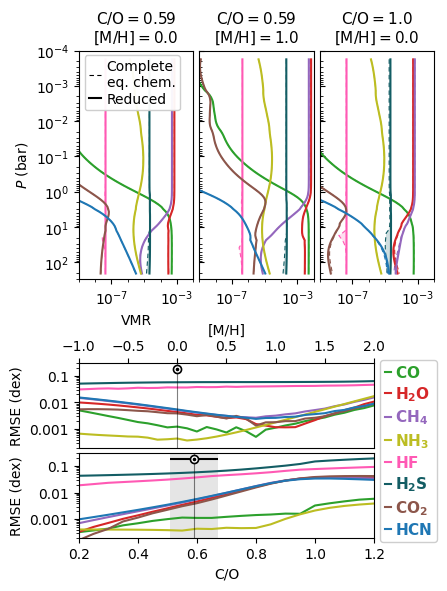

In [44]:
xlim = (1e-9,1e-2)
xticks = [1e-3, 1e-7]
ylim = (3e2, 1e-4)

fig = plt.figure(figsize=(4.5,5.8))
gs = fig.add_gridspec(ncols=6, nrows=4, wspace=0.11, hspace=0.05, height_ratios=[0.95,0.3,0.35,0.35])
ax = np.array([fig.add_subplot(gs[0,:2]), fig.add_subplot(gs[0,2:4]), fig.add_subplot(gs[0,4:])])

_ = Chem_red(ParamTable={'[M/H]':0.}, temperature=temperature)
_ = Chem_full(ParamTable={'[M/H]':0.}, temperature=temperature)
for species_i, (c_i, label_i, j) in species_info.items():
    
    VMR_red = get_VMR(Chem_red, species_i); VMR_full = get_VMR(Chem_full, species_i)

    line, *_ = ax[0].plot(VMR_red, Chem_red.pressure, c=c_i, label=r'$\mathbf{'+label_i+'}$', lw=1.5)
    ax[0].fill_betweenx(Chem_red.pressure, VMR_red, VMR_full, ec='none', fc=line.get_color(), alpha=0.2)
    ax[0].plot(VMR_full, Chem_full.pressure, c=line.get_color(), ls=(0,(4,3)), lw=0.8, zorder=-1)

# """
_ = Chem_red(ParamTable={'[M/H]':1.0}, temperature=temperature)
_ = Chem_full(ParamTable={'[M/H]':1.0}, temperature=temperature)
for species_i, (c_i, label_i, j) in species_info.items():
    
    VMR_red = get_VMR(Chem_red, species_i); VMR_full = get_VMR(Chem_full, species_i)

    line, *_ = ax[1].plot(VMR_red, Chem_red.pressure, c=c_i, label=r'$\mathbf{'+label_i+'}$', lw=1.5)
    ax[1].fill_betweenx(Chem_red.pressure, VMR_red, VMR_full, ec='none', fc=line.get_color(), alpha=0.2)
    ax[1].plot(VMR_full, Chem_full.pressure, c=line.get_color(), ls=(0,(4,3)), lw=0.8, zorder=-1)

CtoO = 1.0
# CtoO = 1.5*10**8.46/10**8.69
a = 1/2*(np.log10(CtoO) - 8.46 + 8.69)
_ = Chem_red(ParamTable={'alpha_C':+a, 'alpha_O':-a}, temperature=temperature)
_ = Chem_full(ParamTable={'alpha_C':+a, 'alpha_O':-a}, temperature=temperature)
for species_i, (c_i, label_i, j) in species_info.items():
    
    VMR_red = get_VMR(Chem_red, species_i); VMR_full = get_VMR(Chem_full, species_i)

    line, *_ = ax[2].plot(VMR_red, Chem_red.pressure, c=c_i, label=r'$\mathbf{'+label_i+'}$', lw=1.5)
    ax[2].fill_betweenx(Chem_red.pressure, VMR_red, VMR_full, ec='none', fc=line.get_color(), alpha=0.2)
    ax[2].plot(VMR_full, Chem_full.pressure, c=line.get_color(), ls=(0,(4,3)), lw=0.8, zorder=-1)
# """
ax[0].set_title(r'$\mathrm{C/O}=0.59$'+'\n'+r'$\mathrm{[M/H]}=0.0$', fontsize=11)
ax[1].set_title(r'$\mathrm{C/O}=0.59$'+'\n'+r'$\mathrm{[M/H]}=1.0$', fontsize=11)
ax[2].set_title(r'$\mathrm{C/O}=1.0$'+'\n'+r'$\mathrm{[M/H]}=0.0$', fontsize=11)

labels, handles = [], []
line, *_ = ax[0].plot([], [], c='k', ls=(0,(4,3)), lw=0.8, label='Complete\neq. chem.', zorder=-1)
labels.append(line.get_label()); handles.append(line)
line, *_ = ax[0].plot([], [], c='k', ls='-', lw=1.5, label='Reduced', zorder=-1)
labels.append(line.get_label()); handles.append(line)
ax[0].legend(
    # handles, labels, loc='upper center', bbox_to_anchor=(0.5,0.92), framealpha=0.95, borderpad=0.3, 
    handles, labels, loc='upper left', bbox_to_anchor=(0.05,0.98), framealpha=0.95, borderpad=0.3, 
    handlelength=0.9, handletextpad=0.4, labelspacing=0.2, borderaxespad=0.0, fontsize=10, 
)

# ax[0].legend(
#     loc='upper left', bbox_to_anchor=(0.05,0.97), frameon=True, framealpha=0.95, borderpad=0.3, 
#     handlelength=0.4, handletextpad=0.3, columnspacing=0.7, labelspacing=0.2, borderaxespad=0.0, 
#     labelcolor='linecolor', fontsize=11, ncols=4, 
# )
# ax[-1].legend(
#     loc='center left', bbox_to_anchor=(1.03,0.5), frameon=True, framealpha=0.95, borderpad=0.3, 
#     handlelength=0.4, handletextpad=0.3, columnspacing=0.7, labelspacing=0.3, borderaxespad=0.0, 
#     labelcolor='linecolor', fontsize=11, ncols=1, 
# )

ax[0].set(
    ylabel=r'$P$ (bar)', xlabel='VMR', xscale='log', yscale='log', xlim=xlim, ylim=ylim, xticks=xticks
    )
ax[0].set_xticks(10**np.arange(-9.,-1.,1), minor=True, labels=[])
for i, ax_i in enumerate(ax[1:]):
    ax_i.set(xscale='log', yscale='log', xlim=xlim, ylim=ylim, yticklabels=[], xticks=xticks)
    ax_i.set_xticks(10**np.arange(-9.,-1.,1), minor=True, labels=[])
    ax_i.tick_params(axis='y', which='both', direction='in')

ax_rms = np.array([fig.add_subplot(gs[-2,:5]), fig.add_subplot(gs[-1,:5])])
        
for species_i, (c_i, label_i, j) in species_info.items():
    ax_rms[0].plot(MtoH_vals, RMSE_MtoH[species_i], c=c_i, label=r'$\mathbf{'+label_i+'}$', lw=1.5)

for species_i, (c_i, label_i, j) in species_info.items():
    ax_rms[1].plot(CtoO_vals, RMSE_CtoO[species_i], c=c_i, label=r'$\mathbf{'+label_i+'}$', lw=1.5)

ax_rms[0].set(
    xlabel=r'[M/H]', xlim=(MtoH_vals.min(), MtoH_vals.max()), ylabel='RMSE (dex)', yscale='log', 
    ylim=(2e-4,3e-1), yticks=[1e-3,1e-2,1e-1], yticklabels=['0.001','0.01','0.1']
)
ax_rms[0].tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax_rms[0].xaxis.set_label_position('top')

ax_rms[1].set(
    xlabel=r'C/O', xlim=(CtoO_vals.min(), CtoO_vals.max()), ylabel='RMSE (dex)', yscale='log', 
    ylim=(2e-4,3e-1), yticks=[1e-3,1e-2,1e-1], yticklabels=['0.001','0.01','0.1']
)

ax_rms[0].axvline(0.0, color='k', lw=0.8, alpha=0.5)
ax_rms[1].axvline(0.59, color='k', lw=0.8, alpha=0.5)
ax_rms[1].axvspan(0.59-0.08, 0.59+0.08, color='k', alpha=0.1, lw=0.)
# """

ax_rms[1].legend(
    loc='center left', bbox_to_anchor=(1.02,1.03), frameon=True, framealpha=0.95, borderpad=0.3, 
    handlelength=0.4, handletextpad=0.3, columnspacing=0.7, labelspacing=0.3, borderaxespad=0.0, 
    labelcolor='linecolor', fontsize=11, ncols=1, 
)

def add_odot(ax, x, y, color='k', ms=5, mec='w', transform=None):
    if transform is None:
        transform = ax.get_xaxis_transform()
    ax.plot([x], [y], 'o', transform=transform, ms=ms, c=color)
    ax.plot([x], [y], 'o', transform=transform, ms=ms*3/5, mfc='none', mec=mec)
    
add_odot(ax_rms[0], 0.0, 0.93, color='k', ms=6, mec='w')
ax_rms[1].errorbar(0.59, 0.93, xerr=0.08, transform=ax_rms[1].get_xaxis_transform(), fmt='', lw=1.5, ms=5, capsize=0, c='k')
add_odot(ax_rms[1], 0.59, 0.93, color='k', ms=6, mec='w')

plt.subplots_adjust(left=0.18, bottom=0.08, top=0.92, right=0.97)
plt.savefig(f'./plots/reduced_chemistry.pdf')
plt.show()

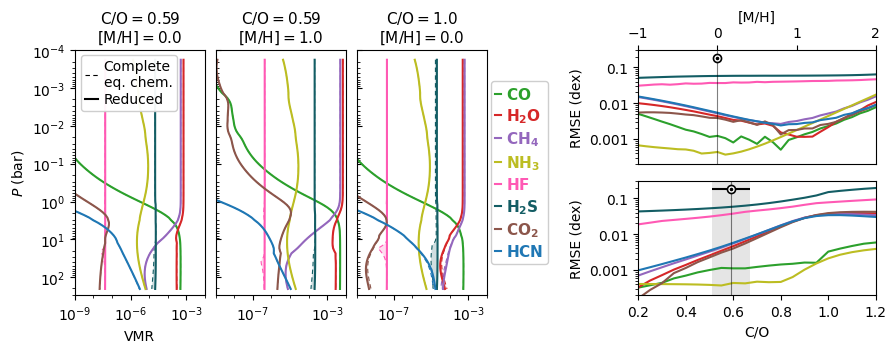

In [46]:
xlim = (1e-9,1e-2)
xticks = [1e-3, 1e-7]
ylim = (3e2, 1e-4)

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=2, ncols=5, wspace=0.07, hspace=0.15, width_ratios=[0.17,0.17,0.17,0.17,0.31])
ax = np.array([fig.add_subplot(gs[:,1]), fig.add_subplot(gs[:,2])])
ax = np.insert(ax, 0, fig.add_subplot(gs[:,0]))

_ = Chem_red(ParamTable={'[M/H]':0.}, temperature=temperature)
_ = Chem_full(ParamTable={'[M/H]':0.}, temperature=temperature)
for species_i, (c_i, label_i, j) in species_info.items():
    
    VMR_red = get_VMR(Chem_red, species_i); VMR_full = get_VMR(Chem_full, species_i)

    line, *_ = ax[0].plot(VMR_red, Chem_red.pressure, c=c_i, label=r'$\mathbf{'+label_i+'}$', lw=1.5)
    ax[0].fill_betweenx(Chem_red.pressure, VMR_red, VMR_full, ec='none', fc=line.get_color(), alpha=0.2)
    ax[0].plot(VMR_full, Chem_full.pressure, c=line.get_color(), ls=(0,(4,3)), lw=0.8, zorder=-1)

# """
_ = Chem_red(ParamTable={'[M/H]':1.0}, temperature=temperature)
_ = Chem_full(ParamTable={'[M/H]':1.0}, temperature=temperature)
for species_i, (c_i, label_i, j) in species_info.items():
    
    VMR_red = get_VMR(Chem_red, species_i); VMR_full = get_VMR(Chem_full, species_i)

    line, *_ = ax[1].plot(VMR_red, Chem_red.pressure, c=c_i, label=r'$\mathbf{'+label_i+'}$', lw=1.5)
    ax[1].fill_betweenx(Chem_red.pressure, VMR_red, VMR_full, ec='none', fc=line.get_color(), alpha=0.2)
    ax[1].plot(VMR_full, Chem_full.pressure, c=line.get_color(), ls=(0,(4,3)), lw=0.8, zorder=-1)

CtoO = 1.0
# CtoO = 1.5*10**8.46/10**8.69
a = 1/2*(np.log10(CtoO) - 8.46 + 8.69)
_ = Chem_red(ParamTable={'alpha_C':+a, 'alpha_O':-a}, temperature=temperature)
_ = Chem_full(ParamTable={'alpha_C':+a, 'alpha_O':-a}, temperature=temperature)
for species_i, (c_i, label_i, j) in species_info.items():
    
    VMR_red = get_VMR(Chem_red, species_i); VMR_full = get_VMR(Chem_full, species_i)

    line, *_ = ax[2].plot(VMR_red, Chem_red.pressure, c=c_i, label=r'$\mathbf{'+label_i+'}$', lw=1.5)
    ax[2].fill_betweenx(Chem_red.pressure, VMR_red, VMR_full, ec='none', fc=line.get_color(), alpha=0.2)
    ax[2].plot(VMR_full, Chem_full.pressure, c=line.get_color(), ls=(0,(4,3)), lw=0.8, zorder=-1)
# """
ax[0].set_title(r'$\mathrm{C/O}=0.59$'+'\n'+r'$\mathrm{[M/H]}=0.0$', fontsize=11)
ax[1].set_title(r'$\mathrm{C/O}=0.59$'+'\n'+r'$\mathrm{[M/H]}=1.0$', fontsize=11)
ax[2].set_title(r'$\mathrm{C/O}=1.0$'+'\n'+r'$\mathrm{[M/H]}=0.0$', fontsize=11)

labels, handles = [], []
line, *_ = ax[0].plot([], [], c='k', ls=(0,(4,3)), lw=0.8, label='Complete\neq. chem.', zorder=-1)
labels.append(line.get_label()); handles.append(line)
line, *_ = ax[0].plot([], [], c='k', ls='-', lw=1.5, label='Reduced', zorder=-1)
labels.append(line.get_label()); handles.append(line)
ax[0].legend(
    # handles, labels, loc='upper center', bbox_to_anchor=(0.5,0.92), framealpha=0.95, borderpad=0.3, 
    handles, labels, loc='upper left', bbox_to_anchor=(0.05,0.98), framealpha=0.95, borderpad=0.3, 
    handlelength=0.9, handletextpad=0.4, labelspacing=0.2, borderaxespad=0.0, fontsize=10, 
)

# ax[0].legend(
#     loc='upper left', bbox_to_anchor=(0.05,0.97), frameon=True, framealpha=0.95, borderpad=0.3, 
#     handlelength=0.4, handletextpad=0.3, columnspacing=0.7, labelspacing=0.2, borderaxespad=0.0, 
#     labelcolor='linecolor', fontsize=11, ncols=4, 
# )
ax[-1].legend(
    loc='center left', bbox_to_anchor=(1.03,0.5), frameon=True, framealpha=0.95, borderpad=0.3, 
    handlelength=0.4, handletextpad=0.3, columnspacing=0.7, labelspacing=0.3, borderaxespad=0.0, 
    labelcolor='linecolor', fontsize=11, ncols=1, 
)

ax[0].set(
    ylabel=r'$P$ (bar)', xlabel='VMR', xscale='log', yscale='log', xlim=xlim, ylim=ylim, 
    )
ax[0].set_xticks(10**np.arange(-9.,-1.,1), minor=True, labels=[])
for i, ax_i in enumerate(ax[1:]):
    ax_i.set(xscale='log', yscale='log', xlim=xlim, ylim=ylim, yticklabels=[], xticks=xticks)
    ax_i.set_xticks(10**np.arange(-9.,-1.,1), minor=True, labels=[])
    ax_i.tick_params(axis='y', which='both', direction='in')

ax_rms = np.array([fig.add_subplot(gs[0,-1]), fig.add_subplot(gs[1,-1])])
        
for species_i, (c_i, label_i, j) in species_info.items():
    ax_rms[0].plot(MtoH_vals, RMSE_MtoH[species_i], c=c_i, label=label_i, lw=1.5)

for species_i, (c_i, label_i, j) in species_info.items():
    ax_rms[1].plot(CtoO_vals, RMSE_CtoO[species_i], c=c_i, label=label_i, lw=1.5)

ax_rms[0].set(
    xlabel=r'[M/H]', xlim=(MtoH_vals.min(), MtoH_vals.max()), ylabel='RMSE (dex)', yscale='log', 
    ylim=(2e-4,3e-1), yticks=[1e-3,1e-2,1e-1], yticklabels=['0.001','0.01','0.1']
)
ax_rms[0].tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax_rms[0].xaxis.set_label_position('top')

ax_rms[1].set(
    xlabel=r'C/O', xlim=(CtoO_vals.min(), CtoO_vals.max()), ylabel='RMSE (dex)', yscale='log', 
    ylim=(2e-4,3e-1), yticks=[1e-3,1e-2,1e-1], yticklabels=['0.001','0.01','0.1']
)

ax_rms[0].axvline(0.0, color='k', lw=0.8, alpha=0.5)
ax_rms[1].axvline(0.59, color='k', lw=0.8, alpha=0.5)
ax_rms[1].axvspan(0.59-0.08, 0.59+0.08, color='k', alpha=0.1, lw=0.)
# """

def add_odot(ax, x, y, color='k', ms=5, mec='w', transform=None):
    if transform is None:
        transform = ax.get_xaxis_transform()
    ax.plot([x], [y], 'o', transform=transform, ms=ms, c=color)
    ax.plot([x], [y], 'o', transform=transform, ms=ms*3/5, mfc='none', mec=mec)
    
add_odot(ax_rms[0], 0.0, 0.93, color='k', ms=6, mec='w')
ax_rms[1].errorbar(0.59, 0.93, xerr=0.08, transform=ax_rms[1].get_xaxis_transform(), fmt='', lw=1.5, ms=5, capsize=0, c='k')
add_odot(ax_rms[1], 0.59, 0.93, color='k', ms=6, mec='w')

plt.subplots_adjust(left=0.08, bottom=0.14, top=0.86, right=0.97)
plt.savefig(f'./plots/reduced_chemistry.pdf')
plt.show()